**Business Understanding**

From last notebook, you may find that many factors have contributed to airbnb prices. In the last part of this project, we are going to build a model to predict the price of aiabnb listings. This prediction will give both hosts and guests a reference for the prices. Besides, this will also influnece many operation and sales strategy of the AirBnB company.

As usual, firstly we will need to import some necessary packages. To do the model fitting, feature selection and feature transformation, we mainly use the functions affilated to Scikit-Learn. 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/price-factors/custom.css
/kaggle/input/price-factors/__results__.html
/kaggle/input/price-factors/Listing_cleaned.csv
/kaggle/input/price-factors/__output__.json
/kaggle/input/price-factors/__notebook__.ipynb
/kaggle/input/price-factors/__results___files/__results___20_1.png
/kaggle/input/price-factors/__results___files/__results___25_1.png
/kaggle/input/price-factors/__results___files/__results___22_1.png
/kaggle/input/price-factors/__results___files/__results___16_1.png
/kaggle/input/price-factors/__results___files/__results___21_1.png
/kaggle/input/price-factors/__results___files/__results___23_1.png
/kaggle/input/price-factors/__results___files/__results___18_1.png
/kaggle/input/price-factors/__results___files/__results___20_2.png
/kaggle/input/price-factors/__results___files/__results___13_0.png


In [2]:
## read the cleaned data from last notebook
df = pd.read_csv('/kaggle/input/price-factors/Listing_cleaned.csv',index_col=0)
print(df.shape)
print(df.select_dtypes(include=['object']).nunique())
print(df.select_dtypes(include=['int','float']).columns)
df.head()

(3818, 65)
host_location                        120
host_response_time                     4
host_acceptance_rate                   2
host_is_superhost                      2
host_neighbourhood                   102
host_has_profile_pic                   2
host_identity_verified                 2
street                              1442
neighbourhood                         81
neighbourhood_cleansed                87
neighbourhood_group_cleansed          17
zipcode                               28
is_location_exact                      2
property_type                         16
room_type                              3
bed_type                               5
amenities                           3284
calendar_updated                      34
instant_bookable                       2
cancellation_policy                    3
require_guest_profile_picture          2
require_guest_phone_verification       2
dtype: int64
Index(['host_response_rate', 'host_listings_count', 'latitude', 'longitude

,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_has_profile_pic,host_identity_verified,street,...,host_days,first_review_days,last_review_days,summary_len,space_len,description_len,neighborhood_overview_len,notes_len,transit_len,host_about_len
0,"Seattle, Washington, United States",within a few hours,96.0,100%,f,Queen Anne,3.0,t,t,"Gilman Dr W, Seattle, WA 98119, United States",...,1973.0,1891.0,368.0,1,180,180,1,1,1,73
1,"Seattle, Washington, United States",within an hour,98.0,100%,t,Queen Anne,6.0,t,t,"7th Avenue West, Seattle, WA 98119, United States",...,1413.0,1234.0,372.0,39,145,152,28,172,28,14
2,"Seattle, Washington, United States",within a few hours,67.0,100%,f,Queen Anne,2.0,t,t,"West Lee Street, Seattle, WA 98119, United States",...,937.0,889.0,489.0,39,188,179,113,29,36,66
3,"Seattle, Washington, United States",NaN,NaN,NaN,f,Queen Anne,1.0,t,t,"8th Avenue West, Seattle, WA 98119, United States",...,1155.0,NaN,NaN,42,1,42,1,1,1,1
4,"Seattle, Washington, United States",within an hour,100.0,NaN,f,Queen Anne,2.0,t,t,"14th Ave W, Seattle, WA 98119, United States",...,1863.0,1639.0,438.0,29,85,174,89,2,56,62


**Data understanding and preparation**

Since we have explored this piece of data in the last notebook, here I will mainly focus on the data preparation for the model later.
One important thing to is to delete those columns with too many invalid values. By doing this, we will give up part of information, but if we keep those features and try to fill in those vacancies by average or median numbers, we will introduce too much bias into our model. Here we set a threshold value and delete all the features that have more than 40% of invalid values. In the end, we deleted four features. And two of them are 'weekly_price' and 'monthly_price'. Those features have very high correlation with our response variable "price". And in the end of the day those two features actually are too strong indicators for price and we have to drop them anyway.  

Another thing to do is to drop those categorical with too many unique categories. The reason is if we convert them into one-hot-vectors, they will produce many very sparse features. It will bring us difficulty to generalize our model. Thus, we drop the features 'street' and 'amenities'. They both have more than 1000 unique categories.

In [3]:
## Find all the columns have more than 40% null values

df.isnull().sum()/df.shape[0]
too_many_NA = []
for col in df.columns:
    if df[col].isnull().sum()/df.shape[0] > 0.4 and col!='price':
        too_many_NA.append(col)
print(too_many_NA)

## Find all the categorical features have more than 1000 unique categories
Categorical_columns = df.select_dtypes(include=['object'])
too_sparse_feature = Categorical_columns.columns[Categorical_columns.nunique() >1000]
print(too_sparse_feature)

['square_feet', 'weekly_price', 'monthly_price', 'security_deposit']
Index(['street', 'amenities'], dtype='object')


We define a function "Clean" to do the final cleaning of our dataset and separate them into training set and test set. 
During the cleaning, we drop all the observations whose response column, in our case "price", has invalid value.
Then we will drop those features with too many NaN and have too many unique categories. 
We also need to get rid of the outliers. The definition of outliers can be very different and complicated. But here we defined 
all the data points whose price is outside the 5%-95% percentile are outliers. In general, we drop all observations with too low or 
too high prices. 

Then we impute all the missing value by the median value of the corresponding column. For all the categorial columns, we
convert them into one-hot-vectors including the category "NaN". And since our response column "price" is not a perfect symmetric normal distribution shape, we include an option to do a box-cox transformation on it (but we may not need it in our final result). Finally, we separate our dataset into a independent variables set and a response variable set. The response variable is our prediction target: "price".

(3440, 544)
(3440,)


Text(0, 0.5, 'Frequency')

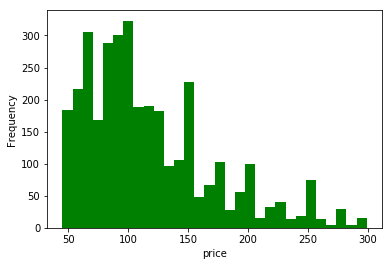

In [4]:
## Do the final cleaning and separate the data into independent variables X, and response variable y.
def Clean(input_df,response_col,too_many_NA,too_sparse_feature,dummy_na,power_transfer=False):
    '''
    INPUT:
    input_df - a dataframe holding all the variables of interest
    response_col - a string holding the target variable name which we want to predict
    too_many_NA - a list contains all the names of features that have too many invalid values
    too_sparse_feature - a list contains all the names of features that have too many unique categories
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    
    X,y - two dataframes, one is training set, one is test set.
    '''
    temp_input_df = input_df.drop(too_many_NA,axis=1)
    temp_input_df = input_df.drop(too_sparse_feature,axis=1)
    temp_input_df = temp_input_df.dropna(subset=[response_col],axis=0)
    temp_input_df = temp_input_df[(temp_input_df[response_col]>=np.percentile(df[response_col],5)) &(temp_input_df[response_col]<=np.percentile(df[response_col],95))]
    
    num_col = temp_input_df.select_dtypes(include=['int','float'])
    for col in num_col:
        temp_input_df[col].fillna(temp_input_df[col].median(),inplace=True)
    
    cat_col = temp_input_df.select_dtypes(include=['object'])
    for col in cat_col:
        try:
            temp_part = pd.get_dummies(temp_input_df[col],dummy_na=dummy_na,prefix_sep='_',prefix=col,drop_first=True)
            temp_input_df = temp_input_df.drop(col,axis=1)
            temp_input_df = pd.concat([temp_input_df,temp_part],axis=1)
        except:
            continue
    X = temp_input_df.drop(response_col,axis=1)
    y = temp_input_df[response_col]
    
    if power_transfer == True:
        bc = PowerTransformer(method = 'box-cox')
        y=y.values.reshape(-1,1)
        bc.fit(y) 
        transformed_y = bc.transform(y)
        return X,transformed_y, bc
    
    elif power_transfer == False:
        return X,y
    
    

## Test function Clean
X,y = Clean(df,response_col='price',too_many_NA=too_many_NA,too_sparse_feature=too_sparse_feature,dummy_na=True)
print(X.shape)
print(y.shape)
plt.hist(y,bins=30,facecolor='g')
plt.xlabel('price')
plt.ylabel('Frequency')

In [5]:
## Finally prepare X and y for building the model
X,y = Clean(df,response_col='price',too_many_NA=too_many_NA,too_sparse_feature=too_sparse_feature,dummy_na=True)

Since now we have 544 features. Some of them might be strongly correlated with each other. And there is also need to do some dimension reduction and decrease number of features to be put in our model. Therefore we applied a very widely used method: Principal Component Analysis. 

The basic idea of principal component analysis is converting those correlated features into a set of orthogonal features. The first principal component will explain the most of the total variability. The importance of one certain principal component is measured by the percentage of total variance it explained. And those principal components are reflecting the actual factors that controll the internal pattern of the whole dataset.

Here we ploted the percentage of variance explained by each principal component to illustrate the meaning of PCA and why it can be used to do feature selection and reduction. 
One thing to note is in practical machine learning pipline implementation, you can only fit the PCA to your training model. Otherwise it will lead to a "data leak" since you already revealed some information about the test set if you fit the PCA transformer on your whole dataset. 

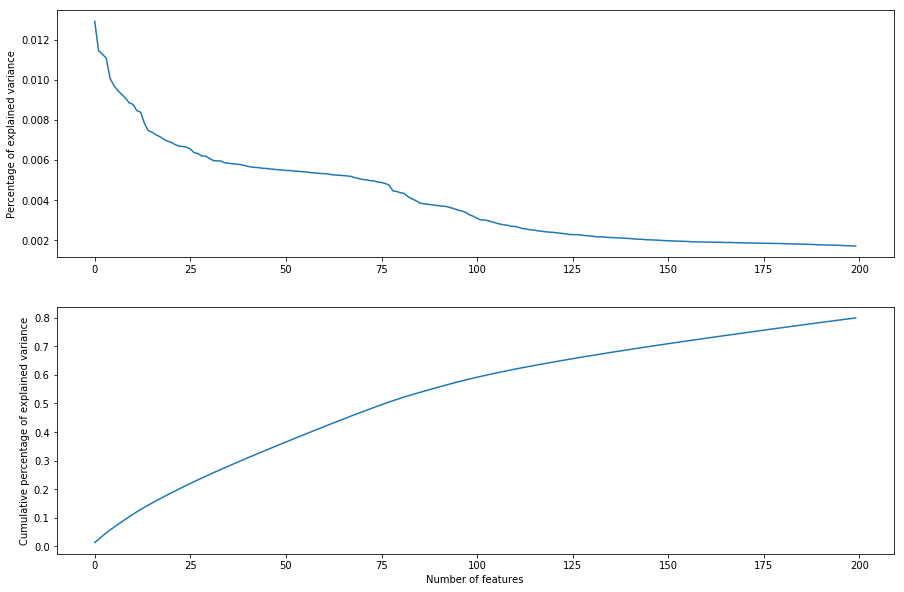

In [6]:
## Illustrate how PCA works and how these principal components explain the total variance
scaler = StandardScaler()
scaler.fit(X)
standardized_X = scaler.transform(X)
pca = PCA(n_components=200)
pca.fit(standardized_X)   
X_transformed = pca.transform(standardized_X)
Sum_explained_variance_ratio=[]
temp=0
for item in pca.explained_variance_ratio_:
    temp += item
    Sum_explained_variance_ratio.append(temp)
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Percentage of explained variance')
plt.subplot(2,1,2)
plt.plot(Sum_explained_variance_ratio)
plt.ylabel('Cumulative percentage of explained variance')
plt.xlabel('Number of features')
plt.show()

**Modeling and evaluation**

Here we begin to build the models. First of all, we built a pipeline for a simple least-square
linear regression model as a baseline. In the pipline, we first standardize the training set. And then we 
apply prinicpal component analysis on the training set to achieve dimension reduction. Finally, we applied a
linear regression model using Scikit-learn. 

We also build a function named "display_results" to show the error metrics, which is
mean square error here, and the plot of the predicted price versus the actual price.

In [7]:
## Define a function to build a linear regression pipeline with rescaling and PCA
def build_linear_model(n_features):
    '''
    INPUT:
    n_features: number of principal components to be kept
    
    OUTPUT:
    pipeline: a machine learning pipline for linear regression model
    '''
    
    pipeline = Pipeline([
        ('scale',StandardScaler()),
        ('pca',PCA(n_components=n_features)),
        ('linear_model',LinearRegression())
        
    ])
    return pipeline

In [8]:
## Define a function to display the model prediction results in training and test set
def display_results(y_test,y_pred_test,y_train,y_pred_train):
    
    '''
    INPUT:
    y_test:actual y values of test set
    y_pred_test: predicted y values of test set
    y_train: actual y values of training set
    y_pred_train: predicted y values of training set
    
    OUTPUT:
    None, print the r2 score and mean squared error on training and test set.
    '''
    
    r2_scores_test=(r2_score(y_test,y_pred_test))
    r2_scores_train=(r2_score(y_train,y_pred_train))
    mean_squared_error_test=(mean_squared_error(y_test,y_pred_test))
    mean_squared_error_train=(mean_squared_error(y_train,y_pred_train))

    print("R2 in test set is {},R2 in training set is {}, mean squared error in test set is {}, mean squared error in training set is {}".format(r2_scores_test,r2_scores_train,mean_squared_error_test,mean_squared_error_train))
    plt.scatter(y_test,y_pred_test)
    plt.title("Predicted y VS Actual y")
    plt.xlabel("Actual y in test set")
    plt.ylabel("Predicted y in test set")
    plt.show()


In [9]:
## The main function of the linear regression model
def main_linear_model(n_features,test_size=0.3,random_state=69):
    '''
    INPUT:
    n_features: number of principal components to be kept
    test_size: the ratio of test set in the total data set
    random_state: the random state in train_test_split
    
    OUTPUT:
    None, conducted the model fitting, prediction, and display the result.
    '''
    
    
    ## Split the dataset into training and test
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_size,random_state=random_state)
    linear_pipline = build_linear_model(n_features=n_features)
    linear_pipline.fit(X_train,y_train)
    y_pred_test = linear_pipline.predict(X_test)
    y_pred_train = linear_pipline.predict(X_train)
    display_results(y_test,y_pred_test,y_train,y_pred_train)

So it doesn't look too bad. The R2 in training is 0.535 and R2 in test is 0.506. The mean squared error in training is 1351.14 and that in test is 1433.75. So both evaluation 
metrics are closed to each other. And it is natural model will have a slightly better permance on the training set. 

And from the visualiztion, we can see that all the prediction values are in a reasonable range. No crazy predictions are observed. So this means this linear model on this dataset is promising. But as a data scientist, we always want to explore any possible optimizations. 

R2 in test set is 0.5026410266665762,R2 in training set is 0.5395534115131102, mean squared error in test set is 1442.4317882838873, mean squared error in training set is 1337.740180911635


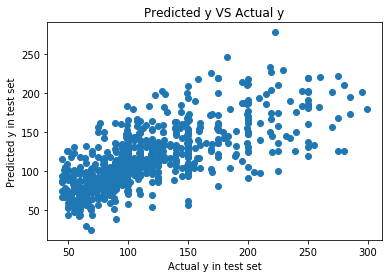

In [10]:
main_linear_model(25,test_size=0.2,random_state=70)

Now we also build another pipline to apply a random forest model and meanwhile implement a random search for 
optimal jyper-parameters. Random forest is said to be a robust model and is very good at dealing with overfitting. 
However, form our experience below, you may find it still depends on the data and its parameters. 

Here we tune three parameters, the number of features to consider when looking for the best split, the maximum depth of each tree, and the number of trees.
A rough random search will be conducted firstly in a wide range of different combinations of parameters. During the search process, we applied a 5-fold cross validation.

In [11]:
## Define a function to build a random forest pipeline with rescaling and PCA, and random search for optimal parameters
def build_rf_model_randomsearch(n_features,max_features,max_depth):
    
    '''
    INPUT:
    n_features: number of principal components to be kept
    max_features: the upper limit of the range you want to search the 'max_features'
    max_depth: the upper limit of the range you want to search the 'max_depth'
    OUTPUT:
    cv: a random search object 
    '''
    
    pipeline = Pipeline([
        ('scale',StandardScaler()),
        ('pca',PCA(n_components=n_features)),
        ('clf',RandomForestRegressor())
    ])
    
    parameters = {
        'clf__max_features':[i for i in range(1,max_features+1)],
        'clf__max_depth':[j for j in range(1,max_depth+1)],
        'clf__n_estimators':[k for k in range(50,1050,50)]
    }
    
    cv = RandomizedSearchCV(pipeline,n_iter=200,param_distributions=parameters,scoring='neg_mean_squared_error',cv=5,verbose=3,n_jobs=-1)
    return cv

After a random search, the random froest have a slightly better result on the test set. Compared to linear regression, the R2 score is increased to 0.539. And the \
mean squared error is decreased to 1338.38. However, you can see a clear overfitting happening in this model. The perfomance on the training set is much better than that on the test set. 

In [12]:
## The main function of the random forest model with random search
def main_rf_random_search(n_features,max_features,max_depth,test_size=0.3,random_state=69):
    '''
    INPUT:
    n_features: number of principal components to be kept
    max_features: the upper limit of the range you want to search the 'max_features'
    max_depth: the upper limit of the range you want to search the 'max_depth'
    test_size: the ratio of test set in the total data set
    random_state: the random state in train_test_split
    
    OUTPUT:
    None, conducted the random forest model fitting, random search on model parameters, prediction, and display the result.
    '''
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_size,random_state=random_state)
    pipeline = build_rf_model_randomsearch(n_features=n_features,max_features=max_features,max_depth=max_depth)
    pipeline.fit(X_train,y_train)
    y_pred_test = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)
    display_results(y_test,y_pred_test,y_train,y_pred_train)
    print("The best model parameters are:",pipeline.best_estimator_.get_params())
    print("The mean squared error of the best model is:",pipeline.best_score_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.5min
/opt/conda/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 44.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 54.0min finished


R2 in test set is 0.5321526349318826,R2 in training set is 0.894599310358444, mean squared error in test set is 1356.8427385881416, mean squared error in training set is 306.2217011807025


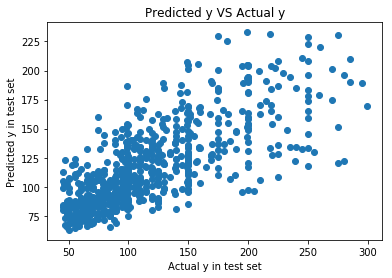

The best model parameters are: {'memory': None, 'steps': [('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=350,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False))], 'verbose': False, 'scale': StandardScaler(copy=True, with_mean=True, with_std=True), 'pca': PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'clf': RandomForestRegressor(bootstrap=True, criterion='mse', 

In [13]:
main_rf_random_search(n_features=25,max_features=25,max_depth=25,test_size=0.2,random_state=70)

After the random search, we will do a more precise grid search in a narrower range. 

In [14]:
## Define a function to build a random forest pipeline with rescaling and PCA, and precise grid search for optimal parameters
def build_rf_model_gridsearch(n_features,max_features_up,max_features_low,max_depth_up,max_depth_low,n_estimators_up,n_estimators_low):
    '''
    INPUT:
    n_features: number of principal components to be kept
    max_features_up: the upper limit of the range you want to search the 'max_features'
    max_features_lower: the lower limit of the range you want to search the 'max_features'
    max_depth_up: the upper limit of the range you want to search the 'max_depth'
    max_depth_lower: the lower limit of the range you want to search the 'max_depth'
    n_estimators_up: the upper limit of the range you want to search the "n_estimators"
    n_estimators_lower: the lower limit of the range you want to search the "n_estimators"
    OUTPUT:
    cv: a grid search object 
    '''
    
    pipeline = Pipeline([
        ('scale',StandardScaler()),
        ('pca',PCA(n_components=n_features)),
        ('clf',RandomForestRegressor())
    ])
    
    parameters = {
        'clf__max_features':[i for i in range(max_features_low,max_features_up)],
        'clf__max_depth':[j for j in range(max_depth_low,max_depth_up)],
        'clf__n_estimators':[z for z in range(n_estimators_low,n_estimators_up,10)]
    }
    
    cv = GridSearchCV(pipeline,param_grid=parameters,scoring='neg_mean_squared_error',cv=5,verbose=3,n_jobs=-1)
    return cv

In [15]:
## The main function of the random forest model with grid search
def main_rf_grid_search(n_features,max_features_up,max_features_low,max_depth_up,max_depth_low,n_estimators_up,n_estimators_low,test_size=0.3,random_state=69):
    '''
    INPUT:
    n_features: number of principal components to be kept
    max_features_up: the upper limit of the range you want to search the 'max_features'
    max_features_lower: the lower limit of the range you want to search the 'max_features'
    max_depth_up: the upper limit of the range you want to search the 'max_depth'
    max_depth_lower: the lower limit of the range you want to search the 'max_depth'
    n_estimators_up: the upper limit of the range you want to search the "n_estimators"
    n_estimators_lower: the lower limit of the range you want to search the "n_estimators"
    test_size: the ratio of test set in the total data set
    random_state: the random state in train_test_split
    
    OUTPUT:
    None, conducted the random forest model fitting, grid search on model parameters, prediction, and display the result.
    '''
    
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_size,random_state=random_state)
    pipeline = build_rf_model_gridsearch(n_features=n_features,max_features_up=max_features_up,max_features_low=max_features_low,
                                         max_depth_up=max_depth_up,max_depth_low=max_depth_low,
                                         n_estimators_up=n_estimators_up,n_estimators_low=n_estimators_low)
    pipeline.fit(X_train,y_train)
    y_pred_test = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)
    display_results(y_test,y_pred_test,y_train,y_pred_train)
    print("The best model parameters are:",pipeline.best_estimator_.get_params())
    print("The mean squared error of the best model is:",pipeline.best_score_)

The grid search has only very tiny improvement on the model performance. 

Fitting 5 folds for each of 147 candidates, totalling 735 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 735 out of 735 | elapsed: 45.1min finished


R2 in test set is 0.5385165417201896,R2 in training set is 0.8934060127522416, mean squared error in test set is 1338.386247519716, mean squared error in training set is 309.68860091569326


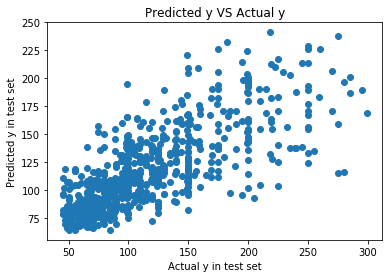

The best model parameters are: {'memory': None, 'steps': [('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=17,
                      max_features=13, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=370,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False))], 'verbose': False, 'scale': StandardScaler(copy=True, with_mean=True, with_std=True), 'pca': PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'clf': RandomForestRegressor(bootstrap=True, criterion='mse',

In [16]:
main_rf_grid_search(n_features=25,max_features_up=20,max_features_low=13,max_depth_up=19,max_depth_low=16,n_estimators_up=420,n_estimators_low=350,test_size=0.2,random_state=70)

**Conclusion**

**The question answered: How can we build a model to predict the price?**

In conclusion, we definitely didn't get a perfect result. But the result of linear regression is already promising. The more complicated random forest can slightly optimize the prediction performance even after parameter tuning. Thus in data science, data cleaning, reasonable feature selection and feature engineering is a key part in the whole process. And in this particular project, a potential future work is to extracting more information from those description messages and do some feature engineering by natural language processing. This is the next step of this program.  